In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import gc       
import os 

# clear out any old junk
gc.collect()

0

In [2]:
!gdown --id 1ns3OatdBxs4n331JZDsESjM4mjdKEZqf
!gdown --id 1riVtDIP0vUrJg0KY811MYjXvlHZz8Fvp
!gdown --id 1yii5h-OKUZ4PSdCf15Ul4AhIybr9_Lzj
!gdown --id 1QcMx8wpN0fInwXEZy8h4etdnfgV4uvMc
!gdown --id 1tOaRs8W8TCgl-igWIaVUteDwFY8JMGiu
!gdown --id 1gXj_eUS9T4G_m1zmWotaeGbGyxYqO7xg
!gdown --id 1qiEABfF1BLyQtjIQYNfMhWT2pgboS1h7
!gdown --id 1bTZNT4lNKHc_DlJvV-nDHwXQFXFB2aCb
!gdown --id 1xOf0rrhW1_rQx1UzwbJxCZ1IJ8Kqb3tw
!gdown --id 1z8zzLwxa47nvl1XrzxFsP2ZPfjVzSYhb

### bureau_balance.csv

In [3]:
bureau_balance = pd.read_csv('bureau_balance.csv')                                           # read the table
print(bureau_balance.shape, "- shape of bureau_balance table")
bb_status = pd.crosstab(bureau_balance.SK_ID_BUREAU, bureau_balance.STATUS, margins = True)             # create pivot table
bb_status.columns = ['BB_'+column for column in bb_status.columns]
print(bb_status.shape, "- shape of bb_status table")
bureau_balance_12 = bureau_balance[bureau_balance.MONTHS_BALANCE > -24]                                 # filter - last 12 months only
bb_status_12 = pd.crosstab(bureau_balance_12.SK_ID_BUREAU, bureau_balance_12.STATUS, margins = True)    # pivot table on filtered data
bb_status_12.columns = ['BB12_'+column for column in bb_status_12.columns]
print(bb_status_12.shape, "- shape of bb_status_12 table")

del bureau_balance            # we are keeping bb_status and bb_status_12 - we can drop the original table and the filtered version
del bureau_balance_12
gc.collect()

(27299925, 3) - shape of bureau_balance table
(817396, 9) - shape of bb_status table
(721535, 9) - shape of bb_status_12 table


0

### bureau.csv

In [4]:
bureau = pd.read_csv('bureau.csv')
print(bureau.shape, "- shape of bureau table")

bureau = bureau.merge(bb_status, left_on = 'SK_ID_BUREAU', right_on = 'SK_ID_BUREAU')               # merge the tables
bureau = bureau.merge(bb_status_12, left_on = 'SK_ID_BUREAU', right_on = 'SK_ID_BUREAU')            # merge the tables
bureau = bureau.drop(['SK_ID_BUREAU'], axis = 1)                                                    # no longer need this key
print(bureau.shape, "- shape of bureau table after merging in bb_status tables")                    # should be 652,144 x 34
bureau.columns = ['BU_'+column if column !='SK_ID_CURR' else column for column in bureau.columns]   # things that start with BU_ came from bureau

# ratio features
bureau['OD_ratio'] = bureau['BU_AMT_CREDIT_SUM_OVERDUE'] / bureau['BU_AMT_CREDIT_SUM_DEBT']   # proportion of debt that is overdue
bureau['Credit_ratio'] = bureau['BU_AMT_CREDIT_SUM'] / bureau['BU_AMT_CREDIT_SUM_LIMIT']      # proportion of credit line used
bureau['Debt_ratio'] = bureau['BU_AMT_CREDIT_SUM_DEBT'] / bureau['BU_AMT_CREDIT_SUM']         # debt percentage
bureau['REMAIN_CRED'] = bureau['BU_AMT_CREDIT_SUM'] - bureau['BU_AMT_CREDIT_SUM_DEBT'] - bureau['BU_AMT_CREDIT_SUM_LIMIT']
bureau['AC_RATIO'] = bureau['BU_AMT_ANNUITY'] / bureau['BU_AMT_CREDIT_SUM']

# numeric features for bureau
bureau_num = bureau.groupby(by=['SK_ID_CURR']).mean().reset_index()                                 # group the numeric features by SK_ID_CURR
print(bureau_num.shape, "- shape of numeric bureau features (incl index)")                          # should be 132,250 x 34

# categorical feagures for bureau
bureau_cat = pd.get_dummies(bureau.select_dtypes('object'))                                         # this got rid of the SK_ID_CURR column ...
bureau_cat['SK_ID_CURR'] = bureau['SK_ID_CURR']                                                     # so we have to replace it
bureau_cat = bureau_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()                           # tried sum - didn't change anything
print(bureau_cat.shape, "- shape of categorical bureau features (incl index)")                      # should be 132,250 x 23

# count feature for bureau
bureau_count = bureau.groupby(by = ['SK_ID_CURR'])['BU_CREDIT_ACTIVE'].count().reset_index()
bureau_count.rename(columns={'BU_CREDIT_ACTIVE':'COUNT_of_BUREAU'})   

# we are keeping bureau_num, bureau_cat and bureau_count - all will be merged into training data
del bureau                   # no longer need this table - its contents were transformed into bureau_num, bureau_cat, bureau_count
del bb_status                # no longer need this table - already merged into bureau
del bb_status_12             # no longer need this table - already merged into bureau
gc.collect()

(1716428, 17) - shape of bureau table
(693550, 34) - shape of bureau table after merging in bb_status tables
(133231, 36) - shape of numeric bureau features (incl index)
(133231, 23) - shape of categorical bureau features (incl index)


0

### previous_application.csv

In [5]:
# This is the original function that derives CALC_RATE, INTEREST_PAID and INT_PRINC.
import numpy_financial as npf
def calc_rate(row):
   return npf.rate(row['CNT_PAYMENT'], -row['AMT_ANNUITY'], row['AMT_CREDIT'], 0, guess = 0.05, maxiter = 10)
previous = pd.read_csv('previous_application.csv')
previous['CALC_RATE'] = previous.apply(calc_rate, axis=1)
previous['INTEREST_PAID'] = previous['AMT_ANNUITY'] * previous['CNT_PAYMENT'] - previous['AMT_CREDIT']
previous['INT_PRINC'] = previous['INTEREST_PAID'] / previous['AMT_CREDIT']

/opt/anaconda3/lib/python3.8/site-packages/numpy_financial/_financial.py:550: RuntimeWarning: divide by zero encountered in double_scalars
  return g / gp
/opt/anaconda3/lib/python3.8/site-packages/numpy_financial/_financial.py:545: RuntimeWarning: invalid value encountered in double_scalars
  g = y + t1*x + p*(t1 - 1) * (r*w + 1) / r
/opt/anaconda3/lib/python3.8/site-packages/numpy_financial/_financial.py:547: RuntimeWarning: invalid value encountered in double_scalars
  - p*(t1 - 1) * (r*w + 1) / (r**2)
/opt/anaconda3/lib/python3.8/site-packages/numpy_financial/_financial.py:548: RuntimeWarning: invalid value encountered in double_scalars
  + n*p*t2 * (r*w + 1) / r
/opt/anaconda3/lib/python3.8/site-packages/numpy_financial/_financial.py:550: RuntimeWarning: invalid value encountered in double_scalars
  return g / gp


In [6]:
%%time


previous.drop(['SK_ID_PREV'], axis = 1, inplace = True)                          # don't need this, merging everything straight to train/test

previous.columns = ['PR_'+column if column !='SK_ID_CURR' else column for column in previous.columns]
previous['PR_DAYS_LAST_DUE'].replace({365243: np.nan}, inplace = True)
previous['PR_DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
previous['PR_DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
previous['PR_DAYS_TERMINATION'].replace({365243: np.nan}, inplace = True)
previous['PR_DAYS_FIRST_DRAWING'].replace({365243: np.nan}, inplace = True)
previous['PR_CApp_RATIO'] = previous['PR_AMT_CREDIT'] / previous['PR_AMT_APPLICATION'] 
previous['PR_AG_RATIO'] = previous['PR_AMT_APPLICATION'] / previous['PR_AMT_GOODS_PRICE'] 
previous['PR_CAnnRATIO'] = previous['PR_AMT_CREDIT'] / previous['PR_AMT_ANNUITY'] 
previous['PR_CG_RATIO'] = previous['PR_AMT_CREDIT'] / previous['PR_AMT_GOODS_PRICE'] 

# Create numeric features by grouping on SK_ID_CURR and finding group means
previous_num = previous.groupby(by=['SK_ID_CURR']).mean().reset_index()         # group the numeric features by SK_ID_CURR
print(previous_num.shape, "- shape of numeric features (incl index)")         

# Create categorical features by creating dummies and then taking group means
previous_cat = pd.get_dummies(previous.select_dtypes('object'))                 # this got rid of the SK_ID_CURR column ...
previous_cat['SK_ID_CURR'] = previous['SK_ID_CURR']                             # so we have to replace it
previous_cat = previous_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()   # could try sum as well.
print(previous_cat.shape, "- shape of categorical features (incl index)")     

# we can keep previous_num and previous_cat - these will be merged into training data
del previous                 # no longer need this table - its contents were transformed into previous_num, previous_cat
gc.collect()

(338857, 27) - shape of numeric features (incl index)
(338857, 144) - shape of categorical features (incl index)
CPU times: user 6 s, sys: 3.76 s, total: 9.76 s
Wall time: 11.4 s


0

### installment_payments.csv

In [7]:
inst = pd.read_csv('installments_payments.csv')
inst.drop(['SK_ID_PREV'], axis=1, inplace = True)
inst.columns = ['IP_'+column if column != 'SK_ID_CURR' else column for column in inst.columns]

inst['PAY_PERCENT'] = inst['IP_AMT_INSTALMENT'] / inst['IP_AMT_PAYMENT']
inst['PAY_DIFF'] = inst['IP_AMT_INSTALMENT'] - inst['IP_AMT_PAYMENT']
inst['DPD'] = inst['IP_DAYS_ENTRY_PAYMENT'] - inst['IP_DAYS_INSTALMENT']
inst['DPD'] = inst['DPD'].apply(lambda x: x if x>0 else 0)
inst['DBD'] = inst['IP_DAYS_INSTALMENT'] - inst['IP_DAYS_ENTRY_PAYMENT']
inst['DBD'] = inst['DBD'].apply(lambda x: x if x>0 else 0)

inst_num = inst.groupby(by=['SK_ID_CURR']).mean().reset_index()         # group the numeric features by SK_ID_CURR
print(inst_num.shape, "- shape of numeric features (incl index)")       # should be 339,587 x 7

# we will keep inst_num and get rid of inst
del inst                    # don't need this anymore
gc.collect()

(339587, 11) - shape of numeric features (incl index)


0

#### POS_CASH_balance.csv

In [8]:
pos = pd.read_csv('POS_CASH_balance.csv')
pos.drop(['SK_ID_PREV'], axis=1, inplace = True)
pos.columns = ['PO_'+column if column != 'SK_ID_CURR' else column for column in pos.columns]

pos_num = pos.groupby(by=['SK_ID_CURR']).mean().reset_index()            # group the numeric features by SK_ID_CURR
print(pos_num.shape, "- shape of numeric features (incl index)")         # should be 337,252 x 6

pos_cat = pd.get_dummies(pos.select_dtypes('object'))                    # this got rid of the SK_ID_CURR column ...
pos_cat['SK_ID_CURR'] = pos['SK_ID_CURR']                                # so we have to replace it
pos_cat = pos_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()      # could try sum as well.
print(pos_cat.shape, "- shape of categorical features (incl index)")     # should be 337,252 x 10

# we will keep pos_num and pos_cat
del pos
gc.collect()

(337252, 6) - shape of numeric features (incl index)
(337252, 10) - shape of categorical features (incl index)


16

### credit_card_balance.csv

In [9]:
ccb = pd.read_csv('credit_card_balance.csv')
ccb.drop(['SK_ID_PREV'], axis=1, inplace = True)
ccb.columns = ['CC_'+column if column != 'SK_ID_CURR' else column for column in ccb.columns]

ccb['DRAW_RATIO'] = ccb['CC_AMT_DRAWINGS_CURRENT'] / ccb['CC_CNT_DRAWINGS_CURRENT']
ccb['RECEIVE_RATIO'] = ccb['CC_AMT_RECIVABLE'] / ccb['CC_AMT_RECEIVABLE_PRINCIPAL']
ccb['RECEIVE_PER'] = ccb['CC_AMT_RECIVABLE'] / ccb['CC_AMT_TOTAL_RECEIVABLE']

ccb_num = ccb.groupby(by=['SK_ID_CURR']).mean().reset_index()            # group the numeric features by SK_ID_CURR
print(ccb_num.shape, "- shape of numeric features (incl index)")         # should be 103,558 x 24

ccb_cat = pd.get_dummies(ccb.select_dtypes('object'))                    # this got rid of the SK_ID_CURR column ...
ccb_cat['SK_ID_CURR'] = ccb['SK_ID_CURR']                                # so we have to replace it
ccb_cat = ccb_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()      # could try sum as well.
print(ccb_cat.shape, "- shape of categorical features (incl index)")     # should be 103,558 x 8

# we will keep ccb_num and ccb_cat
del ccb
gc.collect()

(103558, 24) - shape of numeric features (incl index)
(103558, 8) - shape of categorical features (incl index)


13

### Treatment of main data set (train or test)

In [10]:
train = pd.read_csv('application_train.csv')                          # either application_train or application_test depending on switch

# column drops - Megan suggested many others
train.drop(['ORGANIZATION_TYPE'], axis = 1, inplace = True)              # creates 58 dummies that don't do jack shit - let's get rid of this

# clean up this mess
train['FLAG_365243'] = train['DAYS_EMPLOYED'] == 365243                   # these people are mostly pensioners
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)         # DAYS_EMPLOYED is a powerful feature when you clean up the junk

# ratio features
train['CI_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']        # credit-to-income ratio
train['AI_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']       # annuity-to-income ratio
train['AC_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']             # credit to annuity - basically the term of the loan in years
train['CG_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']         # credit to goods price ratio - how much was financed?

# log features
train['log_INCOME'] = np.log(train['AMT_INCOME_TOTAL'])                    # log of income
train['log_ANNUITY'] = np.log(train['AMT_ANNUITY'])                        # log of annuity
train['log_CREDIT'] = np.log(train['AMT_CREDIT'])                          # log of credit
train['log_GOODS'] = np.log(train['AMT_GOODS_PRICE'])                      # log of goods price

# flag features
train['FLAG_CG_ratio'] = train['AMT_CREDIT'] > train['AMT_GOODS_PRICE']     # FLAG if you borrowed more than the price of the item
train['DAYS_ID_4200'] = train['DAYS_ID_PUBLISH'] < -4200                   # IDs more than about 14 years old are from USSR

# cleanup the ext_sources - and remember, these are columns 40:42 in the training data but 39:41 in the test data!
# objective of this section is to replace missing scores with the ROW average for the scores we do have, and not impute any scores.
# if you don't have ANY scores, you get a score of 0.2 - but there are only about a dozen of these
train['AVG_EXT'] = train.iloc[:,(40-0):(43-0)].sum(axis=1)/(3- train.iloc[:,(40-0):(43-0)].isnull().sum(axis=1))
train['AVG_EXT'].replace(np.nan, 0.2, inplace = True)       
train.EXT_SOURCE_1.fillna(train.AVG_EXT, inplace=True)
train.EXT_SOURCE_2.fillna(train.AVG_EXT, inplace=True)
train.EXT_SOURCE_3.fillna(train.AVG_EXT, inplace=True)
train['EXT_SOURCE_MAX'] = np.max(train.iloc[:,(40-0):(43-0)], axis = 1)
train['EXT_SOURCE_MIN'] = np.min(train.iloc[:,(40-0):(43-0)], axis = 1)

In [11]:
# merge features
DFs_to_merge = [bureau_cat, bureau_count, bureau_num, ccb_cat, ccb_num,
 inst_num, pos_cat, pos_num, previous_cat, previous_num]

for i in range (0, len(DFs_to_merge)):
    train = train.merge(DFs_to_merge[i], on='SK_ID_CURR', how='left')

print(train.shape, "- shape of data after all merges") 

# get rid of any +/- infinity we might have missed
train.replace([np.inf, -np.inf], 0, inplace = True)

gc.collect()

(307511, 416) - shape of data after all merges


0

In [12]:
test = pd.read_csv('application_test.csv')                          # either application_test or application_test depending on switch

# column drops - Megan suggested many others
test.drop(['ORGANIZATION_TYPE'], axis = 1, inplace = True)              # creates 58 dummies that don't do jack shit - let's get rid of this

# clean up this mess
test['FLAG_365243'] = test['DAYS_EMPLOYED'] == 365243                   # these people are mostly pensioners
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)         # DAYS_EMPLOYED is a powerful feature when you clean up the junk

# ratio features
test['CI_ratio'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']        # credit-to-income ratio
test['AI_ratio'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']       # annuity-to-income ratio
test['AC_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']             # credit to annuity - basically the term of the loan in years
test['CG_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']         # credit to goods price ratio - how much was financed?

# log features
test['log_INCOME'] = np.log(test['AMT_INCOME_TOTAL'])                    # log of income
test['log_ANNUITY'] = np.log(test['AMT_ANNUITY'])                        # log of annuity
test['log_CREDIT'] = np.log(test['AMT_CREDIT'])                          # log of credit
test['log_GOODS'] = np.log(test['AMT_GOODS_PRICE'])                      # log of goods price

# flag features
test['FLAG_CG_ratio'] = test['AMT_CREDIT'] > test['AMT_GOODS_PRICE']     # FLAG if you borrowed more than the price of the item
test['DAYS_ID_4200'] = test['DAYS_ID_PUBLISH'] < -4200                   # IDs more than about 14 years old are from USSR

# cleanup the ext_sources - and remember, these are columns 40:42 in the testing data but 39:41 in the test data!
# objective of this section is to replace missing scores with the ROW average for the scores we do have, and not impute any scores.
# if you don't have ANY scores, you get a score of 0.2 - but there are only about a dozen of these
test['AVG_EXT'] = test.iloc[:,(40-0):(43-0)].sum(axis=1)/(3- test.iloc[:,(40-0):(43-0)].isnull().sum(axis=1))
test['AVG_EXT'].replace(np.nan, 0.2, inplace = True)       
test.EXT_SOURCE_1.fillna(test.AVG_EXT, inplace=True)
test.EXT_SOURCE_2.fillna(test.AVG_EXT, inplace=True)
test.EXT_SOURCE_3.fillna(test.AVG_EXT, inplace=True)
test['EXT_SOURCE_MAX'] = np.max(test.iloc[:,(40-0):(43-0)], axis = 1)
test['EXT_SOURCE_MIN'] = np.min(test.iloc[:,(40-0):(43-0)], axis = 1)

In [13]:
train = pd.read_csv('application_train.csv')
train.shape

(307511, 122)

In [14]:
test = pd.read_csv('application_test.csv')        
test.shape

(48744, 121)

In [15]:
# merge features
DFs_to_merge = [bureau_cat, bureau_count, bureau_num, ccb_cat, ccb_num,
 inst_num, pos_cat, pos_num, previous_cat, previous_num]

for i in range (0, len(DFs_to_merge)):
    test = test.merge(DFs_to_merge[i], on='SK_ID_CURR', how='left')

print(test.shape, "- shape of data after all merges") 

# get rid of any +/- infinity we might have missed
test.replace([np.inf, -np.inf], 0, inplace = True)


(48744, 402) - shape of data after all merges


In [16]:
gc.collect()

64

### Import packages

In [17]:
# standard Python tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# special tools for working in Kaggle
import joblib   # save and load ML models
import gc       # garbage collection
import os 
import sklearn
import warnings
# from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# preprocessing steps
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# machine learning models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# from xgboost import XGBClassifier, XGBRegressor
# from xgboost import plot_importance
from sklearn.svm import SVR
from sklearn import datasets

# Optuna
import optuna as op
from optuna import create_study

# cross validation and metrics - remember this competition is scored as area under curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

# clear out any old junk
gc.collect()

# Let's put this someplace where it's easy to find - the proportion split between training and validation data
train_size = 0.75

### Read the training data

In [18]:
# Main table
pd.options.display.max_columns = None
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [19]:
y = train['TARGET'].values
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(['TARGET', 'SK_ID_CURR'], axis = 1), y, stratify = y, test_size=1 - train_size, random_state=1)
print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_valid:',X_valid.shape)
print('Shape of y_valid:',y_valid.shape)

Shape of X_train: (230633, 120)
Shape of y_train: (230633,)
Shape of X_valid: (76878, 120)
Shape of y_valid: (76878,)


### make lists of cat and num features for pipeline, based on dtype

In [20]:
types = np.array([z for z in X_train.dtypes])        # array([dtype('float64'), dtype('float64'), dtype('O'), dtype('O') ...])
all_columns = X_train.columns.values                 # list of all column names
is_num = types != 'object'                           # returns array([False, False, False, False,  True,  True, ...) where True is a numeric variable
num_features = all_columns[is_num].tolist()          # list of all numeric columns
cat_features = all_columns[~is_num].tolist()         # list of all categorical columns

print(len(num_features), "numeric features")
print(len(cat_features), "categorical features")

104 numeric features
16 categorical features


### build model pipeline based on num_cols and cat_cols lists

In [21]:
features = num_features + cat_features

Pipe_num = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'median')),        # tried median, mean, constant strategies
    ('scaler', StandardScaler())       ])

Pipe_cat = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder())        ])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipe_num, num_features),
        ('cat', Pipe_cat, cat_features)])

preprocessor.fit(train[features])
X_train = preprocessor.transform(X_train[features])
X_valid = preprocessor.transform(X_valid[features])

print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)

gc.collect()

Shape of X_train: (230633, 250)
Shape of y_train: (230633,)


72

In [22]:
pd.set_option('display.max_colwidth', None)          
results = pd.DataFrame(columns = ['Model Type','AUC - 10xv', 'AUC - Valid', 'Hyperparameters'])

In [23]:
import lightgbm as lgb

# Models

In [24]:
%%time
warnings.filterwarnings("ignore", category = ConvergenceWarning)    # seems like we are okay if we set the max_iter threshold around 400.

lr_clf = LogisticRegression(max_iter = 400, solver = 'lbfgs')       # lbfgs is running rings around saga

lr_parameters = {"C" : [0.005], "penalty" : ['l2']}
lr_grid = GridSearchCV(lr_clf, lr_parameters, cv=10, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

lr_model = lr_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Logistic Regression',
                          'AUC - 10xv' : lr_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, lr_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : lr_grid.best_params_},
                        ignore_index=True)
results

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 18 s, sys: 6.52 s, total: 24.5 s
Wall time: 9min


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"


### Decision Tree

In [25]:
%%time
dt_clf = DecisionTreeClassifier(random_state=1)
dt_parameters = {'max_depth': [8], 'min_samples_leaf': [10]}

dt_grid = GridSearchCV(dt_clf, dt_parameters, cv=10, refit='True', n_jobs=-1, verbose=0, scoring='roc_auc')
dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Decision Tree',
                          'AUC - 10xv' : dt_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, dt_model.predict_proba(X_valid)[:,1]),
                          'Hyperparameters' : dt_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

CPU times: user 6.91 s, sys: 937 ms, total: 7.85 s
Wall time: 42.7 s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"


In [26]:
results

,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"


### Random Forest

In [27]:
%%time
rf_clf = RandomForestClassifier(random_state=1, n_estimators=100)
rf_parameters = {'max_depth': [39],  'min_samples_leaf': [37]}        # results from Optuna study
rf_grid = GridSearchCV(rf_clf, rf_parameters, cv=10, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Random Forest',
                          'AUC - 10xv' : rf_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, rf_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : rf_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 47.2 s, sys: 760 ms, total: 48 s
Wall time: 5min 16s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.738614,0.745623,"{'max_depth': 39, 'min_samples_leaf': 37}"


### Extra Trees

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

In [29]:
XT_clf = ExtraTreesClassifier(random_state = 1, class_weight = {0: 11.5, 1:1})                     

XT_params={
        'n_estimators': [300],
        'min_samples_leaf': [18],
        'min_samples_split': [8],
    },

XT_grid = GridSearchCV(XT_clf, XT_params, cv=5, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
XT_grid.fit(X_train, y_train)

XT_model = XT_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Extra Trees',
                          'AUC - 10xv' : XT_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, XT_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : XT_grid.best_params_},
                        ignore_index=True)
results

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.738614,0.745623,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.730012,0.737158,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"


### XG Boost

In [30]:
%%time
import xgboost as xgb

XGB_clf = xgb.XGBClassifier() #tree_method = 'gpu_hist', gpu_id = -1)
XGB_parameters = {'max_depth': [6], 'n_estimators' : [200], 'learning_rate' : [0.05], 'gamma' : [0]}

XGB_grid = GridSearchCV(XGB_clf, XGB_parameters, cv=5, n_jobs=-1, verbose=0, scoring='roc_auc')
XGB_grid.fit(X_train, y_train)
XGB_model = XGB_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'XG Boost',
                          'AUC - 10xv' : XGB_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, XGB_model.predict_proba(X_valid)[:,1]),
                          'Hyperparameters' : XGB_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:59:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 21min 5s, sys: 1min 6s, total: 22min 11s
Wall time: 29min 34s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.738614,0.745623,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.730012,0.737158,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"
4,XG Boost,0.753661,0.760220,"{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}"


In [31]:
results

,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.738614,0.745623,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.730012,0.737158,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"
4,XG Boost,0.753661,0.760220,"{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}"


### Light GBM

In [32]:
# %%time
import lightgbm as lgb

params = {'boosting_type': 'gbdt', 'objective': 'binary', 'max_depth': 18,                        # choices for boosting type are 'gbdt', 'rf', 'dart', 'goss'
          'nthread': -1, 'num_leaves': 30, 'learning_rate': 0.02, 'n_estimators' : 1600,          # default learning rate is 0.1 but 0.02 feels like the sweet spot.
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': 80, 'reg_lambda': 20,                                                      # bumping up the alpha parameter gave us a little boost
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class' : 1,                     # about 92% target=0 to 8% target=1 - ratio is about 11.5 to 1
          'metric' : 'auc'
          }
    
LGB_clf = lgb.LGBMClassifier(**params)
LGB_parameters = {'learning_rate': [0.02]}

LGB_grid = GridSearchCV(LGB_clf, LGB_parameters, cv=5, scoring= 'roc_auc')
LGB_grid.fit(X_train, y_train)
LGB_model = LGB_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Light GBM',
                          'AUC - 10xv' : LGB_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, LGB_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : LGB_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.743025,0.747978,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.711780,0.718059,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.738614,0.745623,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.730012,0.737158,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"
4,XG Boost,0.753661,0.760220,"{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}"
5,Light GBM,0.757609,0.763430,{'learning_rate': 0.02}


### Identifying Ensemble Model candidates

[]

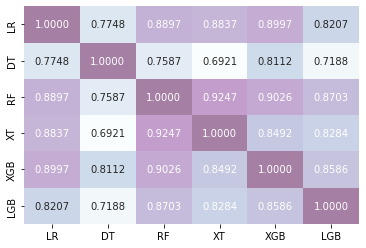

In [33]:
# First, let's capture the predicted probabilities on the validation data set from the models that we liked.
Ens1 = lr_model.predict_proba(X_valid)[:, 1]
Ens2 = dt_model.predict_proba(X_valid)[:, 1]
Ens3 = rf_model.predict_proba(X_valid)[:, 1]
Ens4 = XT_model.predict_proba(X_valid)[:, 1]
Ens5 = XGB_model.predict_proba(X_valid)[:, 1]
Ens6 = LGB_model.predict_proba(X_valid)[:, 1]

EnsDF = pd.DataFrame({'LR' : Ens1, 'DT' : Ens2, 'RF' : Ens3, 'XT' : Ens4, 'XGB' : Ens5, 'LGB' : Ens6})

sns.heatmap(EnsDF.corr(), annot = True, cmap = "BuPu", alpha = 0.5, fmt = ".4f", cbar = False)
plt.plot()

In [34]:
# Candidates for ensemble models:
Scenarios = ('Equal weight', 'Top 5 equal', 'Top 4 equal', 'Top 3 equal', 'Top 2 equal', 'LGB+LR', 'Half LGB half mixed', 
             '70/20/10 blend', '80/15/5 blend', 'Pure LGB')
LR_wt =   (1/6, 1/5, 1/4, 1/3,   0, 1/2,  0.1,  0.1, 0.15,  0)
DT_wt  =  (1/6,   0,   0,   0,   0,   0,  0.1,    0,    0,  0)
RF_wt  =  (1/6, 1/5, 1/4,   0,   0,   0,  0.1,    0, 0.05,  0)
XT_wt  =  (1/6, 1/5,   0,   0,   0,   0,  0.1,  0.2,    0,  0)
XGB_wt  = (1/6, 1/5, 1/4, 1/3, 1/2,   0,  0.1,    0,    0,  0) 
LGB_wt  = (1/6, 1/5, 1/4, 1/3, 1/2, 1/2,  0.5,  0.7,  0.8,  1) 

def Ensemble(a, b, c, d, e, f):
    E = a * Ens1 + b * Ens2 + c * Ens3 + d * Ens4 + e * Ens5 + f * Ens6
    return(np.round(roc_auc_score(y_valid, E),6))

EnsDF_wt = pd.DataFrame({'Scenario' : Scenarios, 'LR' : LR_wt, 'DT' : DT_wt, 'RF' : RF_wt, 'XT' : XT_wt,  'XGB' : XGB_wt, 'LGB' : LGB_wt})
EnsDF_wt['Score'] = EnsDF_wt.apply(lambda row: Ensemble(row['LR'], row['DT'], row['RF'], row['XT'], row['XGB'], row['LGB']),axis = 1)
EnsDF_wt.sort_values('Score', ascending = False)

,Scenario,LR,DT,RF,XT,XGB,LGB,Score
4,Top 2 equal,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.764362
3,Top 3 equal,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.764104
6,Half LGB half mixed,0.100000,0.100000,0.100000,0.100000,0.100000,0.500000,0.763881
2,Top 4 equal,0.250000,0.000000,0.250000,0.000000,0.250000,0.250000,0.763763
1,Top 5 equal,0.200000,0.000000,0.200000,0.200000,0.200000,0.200000,0.763724
8,80/15/5 blend,0.150000,0.000000,0.050000,0.000000,0.000000,0.800000,0.763686
7,70/20/10 blend,0.100000,0.000000,0.000000,0.200000,0.000000,0.700000,0.763645
9,Pure LGB,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.763430
5,LGB+LR,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.763373
0,Equal weight,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.762469


# Visualizing Model Outputs

In [35]:
output_data = pd.DataFrame({'target': y_valid, 'prediction' : LGB_model.predict_proba(X_valid)[:,1]})
output_data['binary'] = np.floor(output_data['prediction'] + 0.5)     # convert probabilistic predictions to 0/1 binary predictions
output_data.head(5)
# output_data.to_pickle("./output.pkl", compression='infer', storage_options=None)

,target,prediction,binary
0,0,0.211743,0.0
1,0,0.532466,1.0
2,0,0.088456,0.0
3,0,0.456025,0.0
4,1,0.402522,0.0


# Final Model Selection - save data


In [36]:
gc.collect()

# Logistic Regression
params_01 = {'C' : 0.005, 'penalty' : 'l2'}
final_model_01 = LogisticRegression(**params_01, max_iter = 400, solver = 'lbfgs')
final_model_01.fit(X_train, y_train)

# Light GBM
final_model_02 = lgb.LGBMClassifier(**params)
final_model_02.fit(X_train, y_train)

# Random Forest
params_03 = {'max_depth' : 39, 'min_samples_leaf' : 37}
final_model_03 = RandomForestClassifier(**params_03, random_state=1, n_estimators=100)
final_model_03.fit(X_train, y_train)

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1


RandomForestClassifier(max_depth=39, min_samples_leaf=37, random_state=1)

# Appendix

### Feature Importance (Light GBM)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


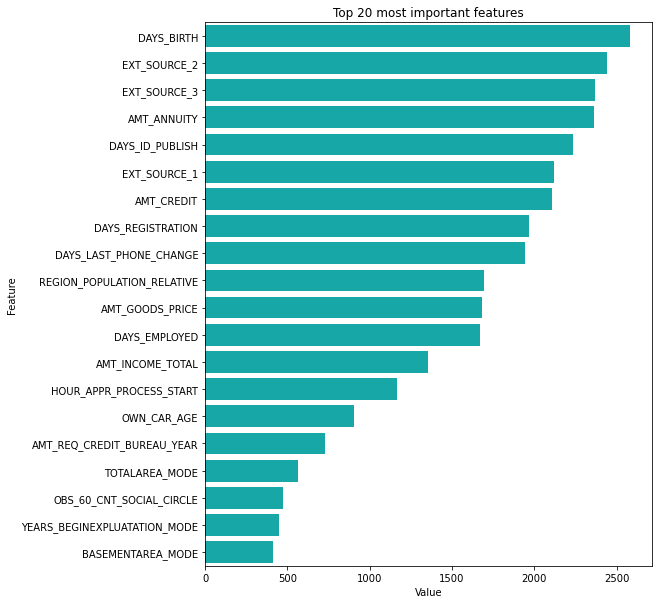

In [37]:
# LGB_model.fit(X_train, y_train)
feature_imp = pd.DataFrame(zip(LGB_model.feature_importances_, features), columns=['Value','Feature']).sort_values(by="Value", ascending=False)

plot_data = feature_imp.iloc[0:20,:]
plt.figure(figsize=[8,10])
sns.barplot(plot_data['Value'], plot_data['Feature'], orient = "h", color="c")
plt.title("Top 20 most important features")
plt.savefig("imp_features")
plt.show()

### Optuna study results for random forest model

In [38]:
import optuna as op
from optuna import create_study
from sklearn import datasets

def objective(trial):
    maxD = trial.suggest_int('max_depth', 30, 40)                            # try integers in the range 30-40
    minSL = trial.suggest_int('min_samples_leaf', 30, 40)
    model = RandomForestClassifier(random_state=1, n_estimators=100, max_depth = maxD, min_samples_leaf = minSL)
    model.fit(X_train[0:20000], y_train[0:20000])                            # for our study, limit the training data to 20,000
    accuracy = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])     # score on roc_auc for the validation data
    return accuracy

study = op.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50, n_jobs = -1)                        # select how many trials we want. Didn't see any improvement after 20 trials
trial = study.best_trial                                                     # ended up being 37 and 30
print("Best Tuning Parameters : {} \n with roc_auc_score of : {:.4f} ".format(trial.params,trial.value))

[I 2022-01-11 00:06:16,801] A new study created in memory with name: no-name-7a09a065-48ac-4adc-8769-1a33c04951d7
/opt/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-01-11 00:06:23,368] Trial 4 finished with value: 0.7293761027600347 and parameters: {'max_depth': 31, 'min_samples_leaf': 39}. Best is trial 4 with value: 0.7293761027600347.
[I 2022-01-11 00:06:23,453] Trial 0 finished with value: 0.729237481404975 and parameters: {'max_depth': 31, 'min_samples_leaf': 36}. Best is trial 4 with value: 0.7293761027600347.
[I 2022-01-11 00:06:23,505] Trial 3 finished with value: 0.7272683572814465 and parameters: {'max_depth': 33, 'min_samples_leaf': 37}. Best is trial 4 with value: 0.7293761027600347.
[I 2022-01-11 00:06:23,676] Trial 2 finished with value: 0.7283912499942543 and parameter

[I 2022-01-11 00:07:06,355] Trial 40 finished with value: 0.7296065432635793 and parameters: {'max_depth': 37, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.7303775427549682.
[I 2022-01-11 00:07:06,785] Trial 41 finished with value: 0.7296065432635793 and parameters: {'max_depth': 37, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.7303775427549682.
[I 2022-01-11 00:07:07,050] Trial 42 finished with value: 0.7296065432635793 and parameters: {'max_depth': 37, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.7303775427549682.
[I 2022-01-11 00:07:07,103] Trial 43 finished with value: 0.7296065432635793 and parameters: {'max_depth': 37, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.7303775427549682.
[I 2022-01-11 00:07:07,208] Trial 44 finished with value: 0.7296065432635793 and parameters: {'max_depth': 37, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.7303775427549682.
[I 2022-01-11 00:07:07,213] Trial 45 finished with value: 0.729606543263579

Best Tuning Parameters : {'max_depth': 37, 'min_samples_leaf': 30} 
 with roc_auc_score of : 0.7304 


### Optuna study results for LGBM

In [39]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna as op
from optuna import create_study
from sklearn import datasets

params = {'boosting_type': 'gbdt', 'objective': 'binary',                           # choices for boosting type are 'gbdt', 'rf', 'dart', 'goss'     
          'n_jobs': -1, 'learning_rate': 0.02,                                      # default learning rate is 0.1 - lower numbers are working well
          'n_estimators' : 1600, 'num_leaves' : 28, 'max_depth' : 18,               # these all seem pretty reasonable
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8,                             # 'reg_alpha': 20, 'reg_lambda': 20, 
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class' : 1,       # about 92% target=0 to 8% target=1 - ratio is about 11.5 to 1
          'metric' : 'auc'
          }

def objective(trial):
    l1 = trial.suggest_int('lambda_l1', 0,8)                              # try integers in the range 30-40
    l2 = trial.suggest_int('lambda_l2', 0,8)
    model = LGBMClassifier(**params, random_state=1, lambda_l1 = l1 * 5, lambda_l2 = l2 * 5)
    model.fit(X_train[0:1000], y_train[0:1000])                                              # for our study, limit the training data to 20,000
    accuracy = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])     # score on roc_auc for the validation data
    return accuracy

study = op.create_study(direction = "maximize")
study.optimize(objective, n_trials = 20, n_jobs = -1)                        # select how many trials we want. Didn't see any improvement after 20 trials
trial = study.best_trial                                                      # looks like good values are ~28 leaves, ~2400 estimators, max depth ~18
print("Best Tuning Parameters : {} \n with roc_auc_score of : {:.4f} ".format(trial.params,trial.value))


# Final Model Evaluation

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(font_scale = 1.2)
output_data = pd.DataFrame({'target': y_valid, 'prediction' : LGB_model.predict_proba(X_valid)[:,1]})
output_data['binary'] = np.floor(output_data['prediction']+0.5)     # one of many ways to convert probabilistic predictions to 0/1 binary predictions

### Plotting the ROC-AUC curve and Precision-Recall Curve

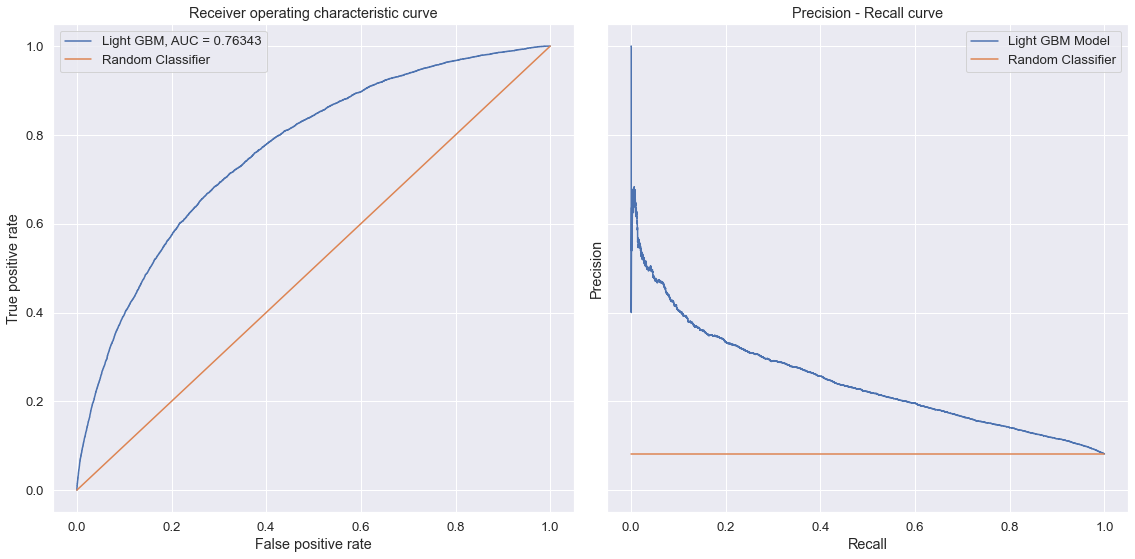

In [41]:
plt.subplots(1, 2, sharey = True, figsize=(16,8))

probabilities = output_data.prediction
fpr, tpr, thresholds = roc_curve(output_data.target, output_data.prediction)
prec, rec, thresholds = precision_recall_curve(output_data.target, output_data.prediction)
auc = roc_auc_score(output_data.target, output_data.prediction)
no_skill = len(output_data[output_data.target==1]) / len(output_data)

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label = f'Light GBM, AUC = {np.round(auc,6)}')      # plot the ROC
plt.plot([0, 1], [0, 1], label='Random Classifier')                             # plot the orange 45 degree line (sometimes called the "no skill" line)
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label='Light GBM Model')                           # plot the PRC
plt.plot([0, 1], [no_skill, no_skill], label='Random Classifier')               # plot the no skill line
plt.title('Precision - Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

### Model Statistics: Accuracy, Recall and Precision

In [42]:
CR = pd.DataFrame(classification_report(output_data.target, output_data.binary, output_dict=True)).T
CR

,precision,recall,f1-score,support
0,0.961572,0.718757,0.822621,70672.000000
1,0.173624,0.672897,0.276026,6206.000000
accuracy,0.715055,0.715055,0.715055,0.715055
macro avg,0.567598,0.695827,0.549323,76878.000000
weighted avg,0.897965,0.715055,0.778497,76878.000000


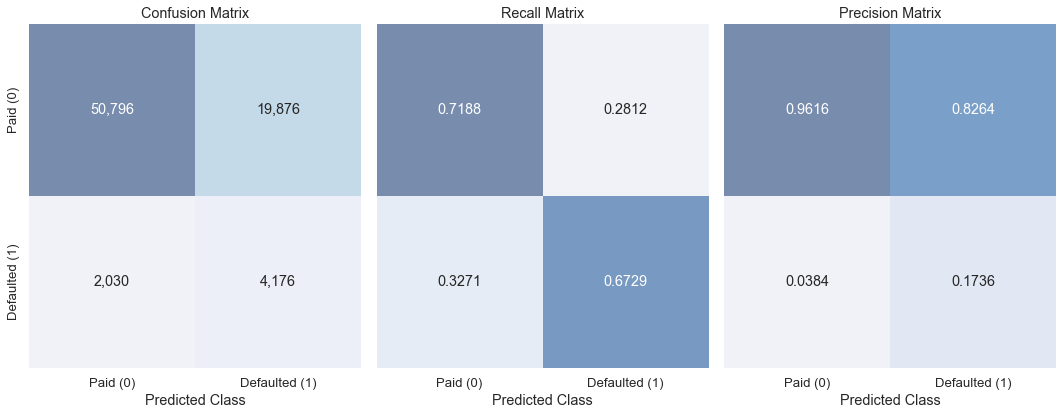

In [43]:
labels = ['Paid (0)','Defaulted (1)']

CM = confusion_matrix(output_data.target, output_data.binary)              # confusion matrix
RM = (((CM.T)/(CM.sum(axis=1))).T)                           # recall matrix
PM = (CM/CM.sum(axis=0))                                     # precision matrix

plots = [CM, RM, PM]
plot_titles = ['Confusion Matrix', 'Recall Matrix', 'Precision Matrix']
formats = [",d", ".4f", ".4f"]
fig, axes = plt.subplots(1, 3, sharey = True, figsize=(15,6))
# fig.supylabel('Actual Class')
# plt.ylabel('Actual Class')
for i in range(0,3):
    plt.subplot(1,3,i+1)
    sns.heatmap(plots[i], annot=True, cmap='Blues', alpha = 0.5, fmt = formats[i], xticklabels = labels, yticklabels=labels, cbar = False)
    plt.xlabel('Predicted Class')
    plt.title(plot_titles[i])

# plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

### Separation between classes

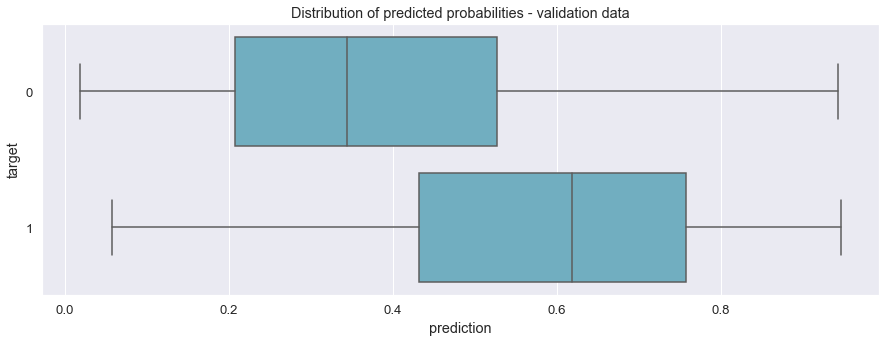

In [44]:
plt.figure(figsize=[15,5])
sns.boxplot(output_data.prediction, output_data.target, orient = "h",color='c')
plt.title('Distribution of predicted probabilities - validation data')
plt.show()